In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objs as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output


In [2]:
boys = pd.read_csv('Boys name.csv')
girls = pd.read_csv('Girls name.csv')

In [3]:
boys = boys.drop('UNIT', axis=1)
girls = girls.drop('UNIT', axis=1)

In [4]:
boys = boys.drop('Statistic Label', axis=1)
girls = girls.drop('Statistic Label', axis=1)

In [5]:
boys.insert(0, 'Gender', 'Boy')

In [6]:
girls.insert(0, 'Gender', 'Girl')

In [7]:
dataframes = [boys, girls]

In [8]:
data = pd.concat(dataframes)
data

,Gender,Year,Names,VALUE
0,Boy,1964,Jack,NaN
1,Boy,1964,Sean,38.0
2,Boy,1964,Conor,56.0
3,Boy,1964,Daniel,19.0
4,Boy,1964,James,5.0
...,...,...,...,...
432475,Girl,2023,Tayah,3.0
432476,Girl,2023,Tiaraoluwa,5.0
432477,Girl,2023,Vedika,3.0
432478,Girl,2023,Wateen,5.0


In [9]:
# Group by year, name, and gender, and sum the counts
data = data.groupby(['Year', 'Names', 'Gender'], as_index=False)['VALUE'].sum()

# Pivot the data to have years as the index and names as columns
pivot_data = data.pivot_table(index='Year', columns=['Names', 'Gender'], values='VALUE', fill_value=0)


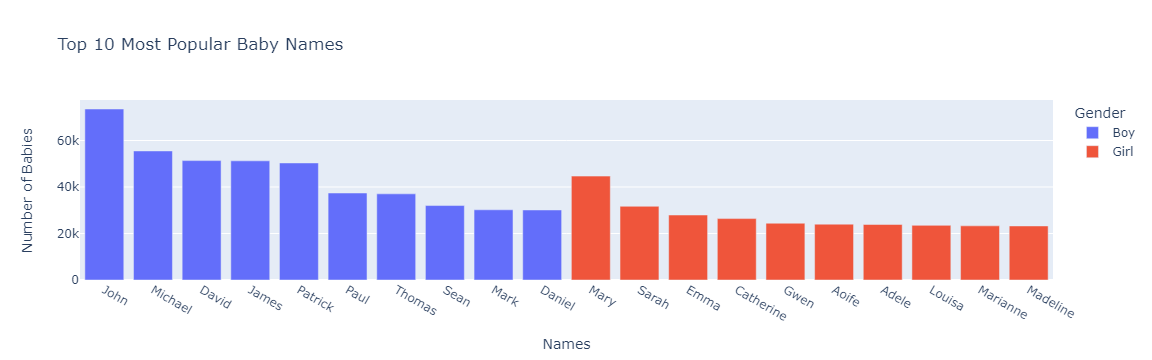

In [28]:
df = pd.DataFrame(data)

# Aggregate data by gender and sum the values
df_agg = df.groupby(['Gender', 'Names']).sum().reset_index()

# Select the top N most popular names for each gender
N = 10  # Change N to select more or fewer names
df_top_names = df_agg.groupby('Gender').apply(lambda x: x.nlargest(N, 'VALUE')).reset_index(drop=True)

# Visual overview of baby name popularity
fig = px.bar(df_top_names, x='Names', y='VALUE', color='Gender', title='Top {} Most Popular Baby Names'.format(N))
fig.update_layout(xaxis_title='Names', yaxis_title='Number of Babies')
fig.show()

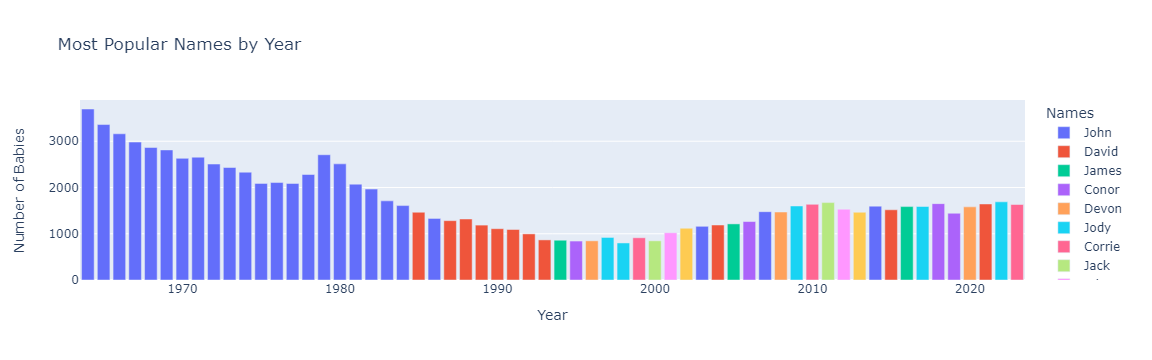

In [30]:
# Group by year and name, and sum the counts
df_agg = df.groupby(['Year', 'Names']).sum().reset_index()

# Find the most popular name for each year
most_popular_names = df_agg.loc[df_agg.groupby('Year')['VALUE'].idxmax()]

# Visualize the most popular names by year
fig = px.bar(most_popular_names, x='Year', y='VALUE', color='Names',
             title='Most Popular Names by Year', labels={'VALUE': 'Number of Babies'})
fig.update_layout(xaxis_title='Year', yaxis_title='Number of Babies')
fig.show()

In [35]:
data = data

# Group by year, name, and gender, and sum the counts
data = data.groupby(['Year', 'Names', 'Gender']).sum().reset_index()

In [43]:
df = pd.DataFrame(data)

# Initialize the Dash app
app1 = dash.Dash(__name__)

# Layout of the app
app1.layout = html.Div([
    html.H1("Baby Name Popularity Over Time"),
    dcc.Dropdown(
        id='gender-dropdown',
        options=[{'label': gender, 'value': gender} for gender in df['Gender'].unique()],
        value=df['Gender'].unique()[0],  # Default value
        multi=False
    ),
    dcc.Dropdown(
        id='name-dropdown',
        options=[],
        value=[],
        multi=True
    ),
    dcc.Graph(id='popularity-chart')
])

# Callback to update the name dropdown based on the selected gender
@app1.callback(
    Output('name-dropdown', 'options'),
    Input('gender-dropdown', 'value')
)
def update_name_dropdown(selected_gender):
    filtered_names = df[df['Gender'] == selected_gender]['Names'].unique()
    return [{'label': name, 'value': name} for name in filtered_names]

# Callback to update the popularity chart
@app1.callback(
    Output('popularity-chart', 'figure'),
    Input('gender-dropdown', 'value'),
    Input('name-dropdown', 'value')
)
def update_popularity_chart(selected_gender, selected_names):
    filtered_data = df[(df['Gender'] == selected_gender) & (df['Names'].isin(selected_names))]
    fig = go.Figure()
    for name in selected_names:
        name_data = filtered_data[filtered_data['Names'] == name]
        fig.add_trace(go.Scatter(x=name_data['Year'], y=name_data['VALUE'], mode='lines+markers', name=name))
    fig.update_layout(title='Popularity of Names Over Time', xaxis_title='Year', yaxis_title='Number of Babies')
    return fig


# Initialize the Dash app
app2 = Dash(__name__)

# Layout of the app
app2.layout = html.Div([
    html.H1("Trends and Cycles in Baby Names Over Time"),
    dcc.Dropdown(
        id='gender-dropdown',
        options=[{'label': gender, 'value': gender} for gender in data['Gender'].unique()],
        value=data['Gender'].unique()[0],  # Default value
        multi=False
    ),
    dcc.Dropdown(
        id='name-dropdown',
        options=[],
        value=None,
        multi=False
    ),
    dcc.Graph(id='time-series-chart'),
    dcc.Graph(id='decomposition-chart')
])

# Callback to update the name dropdown based on the selected gender
@app2.callback(
    Output('name-dropdown', 'options'),
    Input('gender-dropdown', 'value')
)
def update_name_dropdown(selected_gender):
    filtered_names = data[data['Gender'] == selected_gender]['Names'].unique()
    return [{'label': name, 'value': name} for name in filtered_names]

# Callback to update the time series chart
@app2.callback(
    Output('time-series-chart', 'figure'),
    Input('name-dropdown', 'value'),
    Input('gender-dropdown', 'value')
)
def update_time_series(selected_name, selected_gender):
    if selected_name is None:
        # Handle the case when no name is selected
        return {}

    filtered_data = data[(data['Names'] == selected_name) & (data['Gender'] == selected_gender)]
    name_data = filtered_data.pivot(index='Year', columns='Names', values='VALUE').fillna(0)
    
    fig = px.line(
        name_data[selected_name],
        title=f"Trend and Cycles in the Name '{selected_name}' Over Time",
        labels={'index': 'Year', 'value': 'Number of Babies'},
        template='plotly_white'
    )
    fig.update_layout(xaxis_title='Year', yaxis_title='Number of Babies')

    return fig

# Callback to update the decomposition chart
@app2.callback(
    Output('decomposition-chart', 'figure'),
    Input('name-dropdown', 'value'),
    Input('gender-dropdown', 'value')
)
def update_decomposition(selected_name, selected_gender):
    if selected_name is None:
        # Handle the case when no name is selected
        return {}

    filtered_data = data[(data['Names'] == selected_name) & (data['Gender'] == selected_gender)]
    name_data = filtered_data.pivot(index='Year', columns='Names', values='VALUE').fillna(0)
    name_data = name_data[selected_name].dropna()

    decomposition = seasonal_decompose(name_data, model='additive', period=10)

    fig = px.line(template='plotly_white')

    fig.add_scatter(x=name_data.index, y=decomposition.trend, mode='lines', name='Trend')
    fig.add_scatter(x=name_data.index, y=decomposition.seasonal, mode='lines', name='Seasonal')
    fig.add_scatter(x=name_data.index, y=decomposition.resid, mode='lines', name='Residual')

    fig.update_layout(
        title=f"Decomposition of '{selected_name}'",
        xaxis_title='Year',
        yaxis_title='Value'
    )

    return fig

# Run the apps on different ports
if __name__ == '__main__':
    app1.run_server(port=8050, debug=True)
    app2.run_server(port=8051, debug=True)